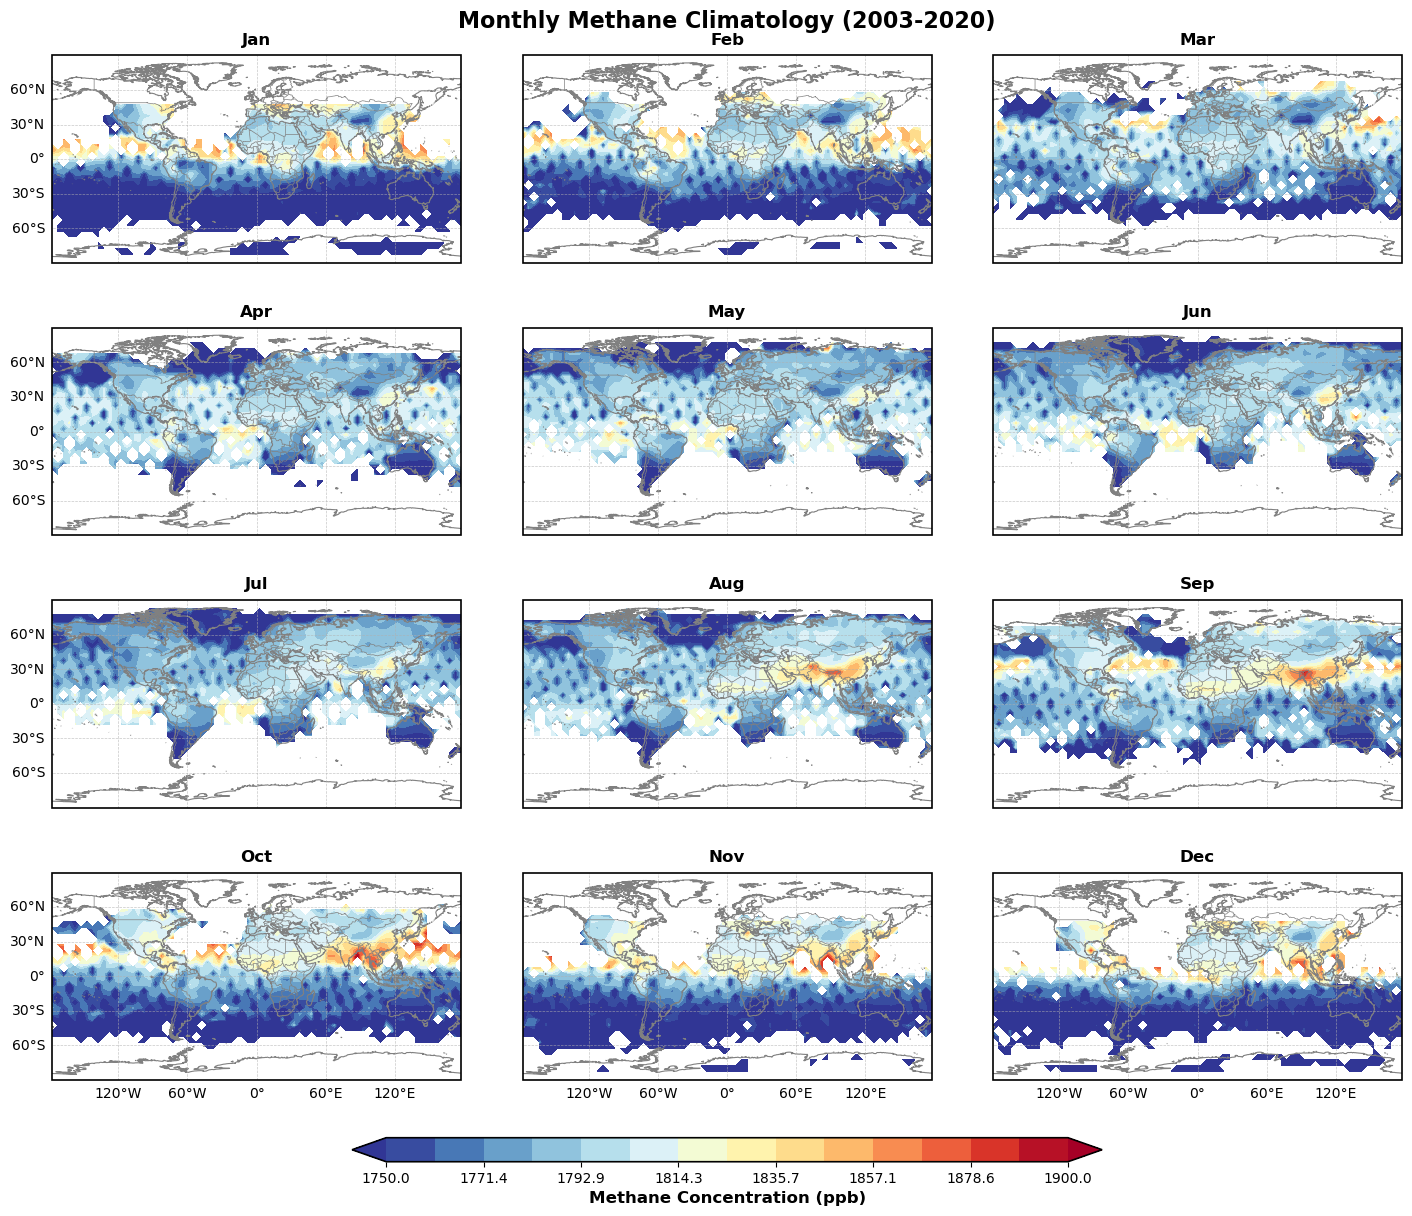

In [4]:
# --- Calculate Monthly Methane Climatology ---
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib as mpl

# Set font and style parameters
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.linewidth'] = 1.2

# Load data file
data_file = '200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc'
dataset = xr.open_dataset(data_file)

# Convert data units to ppb
methane_data = dataset['xch4'] * 1e9

# Calculate monthly climatology
monthly_climatology = methane_data.groupby('time.month').mean(dim='time')

# Create figure
fig = plt.figure(figsize=(15, 12))
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Set consistent color range
data_min = 1750
data_max = 1900

# Plot each month
for month_idx in range(12):
    ax = fig.add_subplot(4, 3, month_idx + 1, projection=ccrs.PlateCarree())
    
    # Extract monthly data
    monthly_data = monthly_climatology.sel(month=month_idx + 1)
    
    # Create filled contour plot
    contour_plot = ax.contourf(dataset.lon, dataset.lat, monthly_data,
                             levels=np.linspace(data_min, data_max, 15),
                             cmap='RdYlBu_r',
                             transform=ccrs.PlateCarree(),
                             extend='both')
    
    # Add coastlines and country borders
    ax.coastlines(resolution='50m', color='gray', linewidth=0.8)
    ax.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=0.5, edgecolor='gray')
    
    # Set subplot title
    ax.set_title(f'{month_names[month_idx]}', fontsize=12, pad=8, fontweight='bold')
    
    # Configure gridlines
    grid_lines = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.7, linewidth=0.5)
    grid_lines.top_labels = False
    grid_lines.right_labels = False
    grid_lines.xformatter = LONGITUDE_FORMATTER
    grid_lines.yformatter = LATITUDE_FORMATTER
    
    # Only show labels on left and bottom subplots
    if month_idx % 3 != 0:
        grid_lines.left_labels = False
    if month_idx < 9:
        grid_lines.bottom_labels = False

# Adjust subplot spacing
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.08, top=0.95, 
                    wspace=0.15, hspace=0.2)

# Add colorbar
colorbar_ax = fig.add_axes([0.25, 0.02, 0.5, 0.02])
colorbar = fig.colorbar(contour_plot, cax=colorbar_ax, 
                       orientation='horizontal', 
                       label='Methane Concentration (ppb)')
colorbar.set_label('Methane Concentration (ppb)', fontsize=12, fontweight='bold')

# Add main title
plt.suptitle('Monthly Methane Climatology (2003-2020)', 
             fontsize=16, fontweight='bold', y=0.98)

plt.show()

# Close dataset
dataset.close()

这是12个分月面板的全球甲烷浓度（ppb）空间分布图，展示了2003 - 2020年各月份的甲烷气候态（即多年平均的月分布特征）。
颜色从深蓝（~1750 ppb）到深红（~1900 ppb）代表甲烷浓度递增；
可清晰看到甲烷浓度的季节和区域差异：例如北半球夏季（如9月）中高纬度地区浓度较高，而南半球海洋区域浓度相对较低，体现了湿地排放、人为活动等因素的季节 - 空间影响。

数据缺失值数量: 1
数据长度: 210
存在缺失值，进行线性插值...


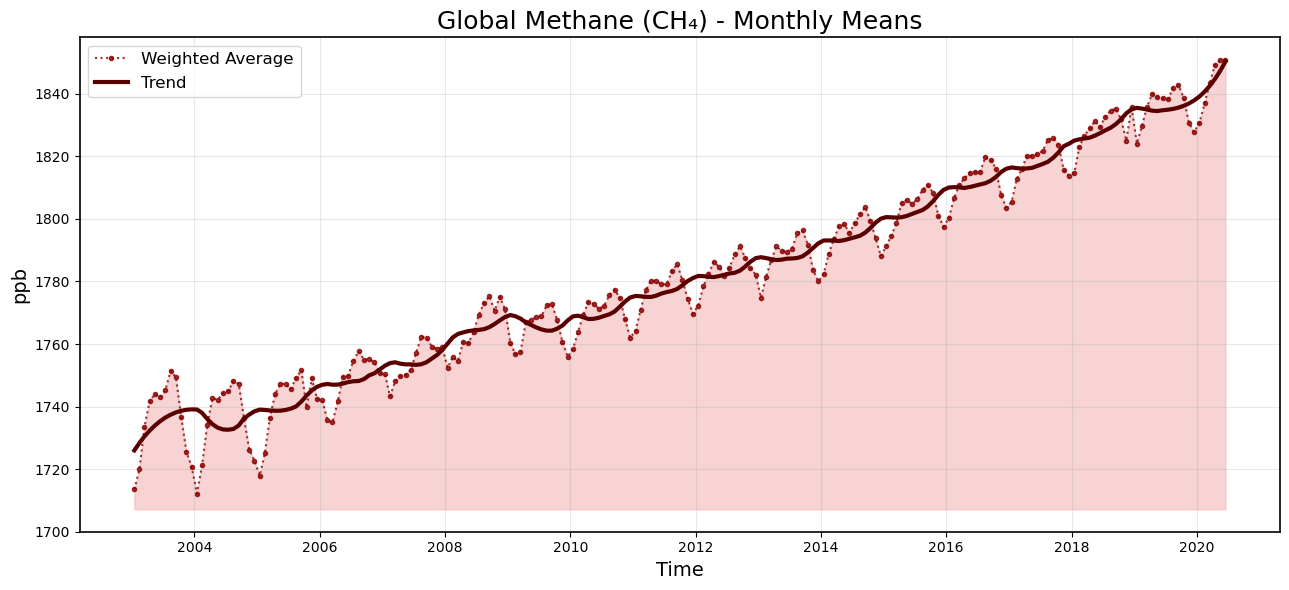

甲烷浓度范围: 1712.1 - 1850.9 ppb
使用的窗口长度: 25


In [12]:
# 1.2 全球加权平均甲烷浓度时间序列

# 1. 计算加权因子：cos(纬度)
weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

# 2. 计算加权平均（转换为ppb）
xch4_ppb = xch4 * 1e9  # 转换为ppb
xch4_weighted = xch4_ppb.weighted(weights)
global_mean = xch4_weighted.mean(dim=("lat", "lon"))

# 3. 计算趋势线
from scipy.signal import savgol_filter
gm = global_mean.values
time_numeric = np.arange(len(gm))  # 使用数值索引作为时间

# 检查并处理缺失值
print(f"数据缺失值数量: {np.isnan(gm).sum()}")
print(f"数据长度: {len(gm)}")

# 如果有缺失值，进行插值
if np.isnan(gm).any():
    print("存在缺失值，进行线性插值...")
    # 创建有效值的掩码
    valid_mask = ~np.isnan(gm)
    # 对时间序列进行插值
    from scipy import interpolate
    if np.sum(valid_mask) > 1:  # 确保有足够的有效点
        f = interpolate.interp1d(time_numeric[valid_mask], gm[valid_mask], 
                               kind='linear', fill_value='extrapolate')
        gm = f(time_numeric)

# 计算趋势线（调整窗口参数）
window_length = min(25, len(gm) - 1)  # 确保窗口长度不超过数据长度
if window_length % 2 == 0:  # 确保窗口长度为奇数
    window_length -= 1

trend = savgol_filter(gm, window_length=window_length, polyorder=3)

# 4. 绘图
plt.figure(figsize=(13, 6))

# 获取原始时间数据用于绘图
original_time = ds['time'].values

# 填充区域
plt.fill_between(original_time, gm, gm.min()-5, color='#f2b6b6', alpha=0.6)

# 原始数据点线
plt.plot(original_time, gm, linestyle=':', marker='o', markersize=3, 
         color='#8B0000', alpha=0.8, label='Weighted Average')

# 趋势线
plt.plot(original_time, trend, color='#5a0000', linewidth=3, label='Trend')

# 设置图表样式
plt.title("Global Methane (CH₄) - Monthly Means", fontsize=18)
plt.ylabel("ppb", fontsize=14)
plt.xlabel("Time", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# 输出统计信息
print(f"甲烷浓度范围: {gm.min():.1f} - {gm.max():.1f} ppb")
print(f"使用的窗口长度: {window_length}")

这是2003 - 2020年全球加权平均甲烷的月均值时间序列，包含“月均值（带点曲线）”和“趋势线（平滑曲线）”：
核心特征是甲烷浓度整体呈显著上升趋势：从2003年约1720 ppb升至2020年的近1850 ppb；
曲线中的波动是季节周期信号（如每年的小幅起伏），而趋势线则剥离了季节波动，体现了长期增长的趋势（与人类活动、自然源排放的长期变化相关）。

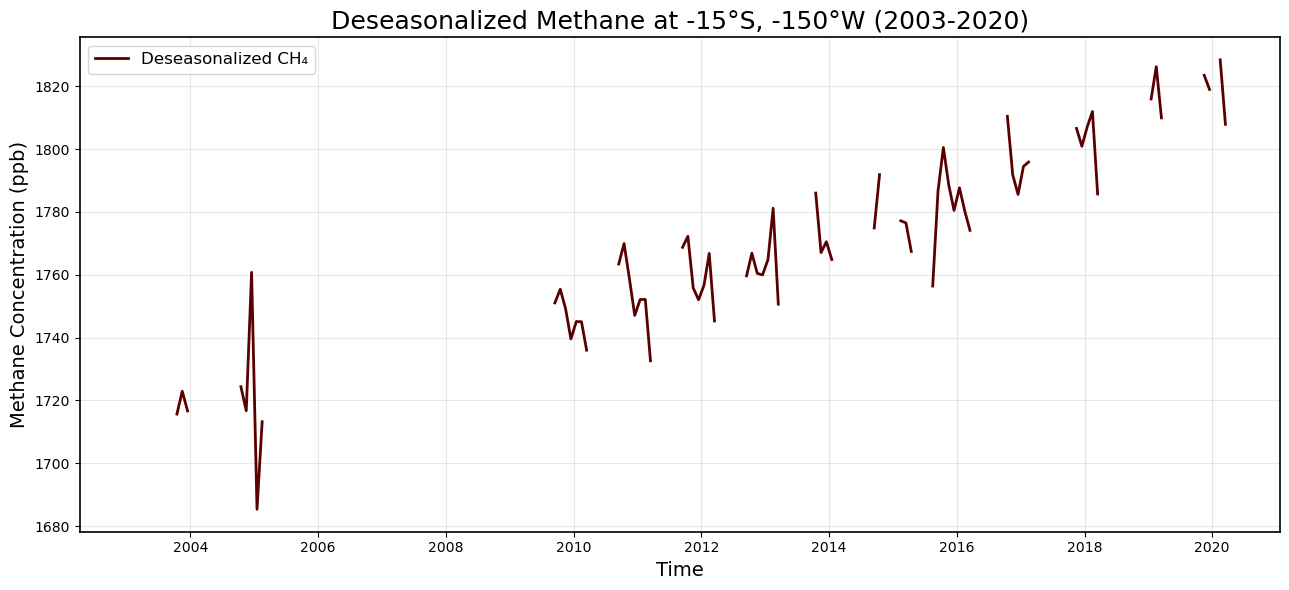

In [15]:
# 1.3 南太平洋指定点位甲烷浓度去季节化时间序列

# 1. 选取指定点位 (15°S, 150°W) 的时间序列（转换为ppb）
point_lat = -15
point_lon = -150
point_data = xch4.sel(lat=point_lat, lon=point_lon, method='nearest') * 1e9  # 转换为ppb

# 2. 计算该点位的月平均气候值 (Seasonal Climatology)
point_clim = point_data.groupby('time.month').mean('time')

# 3. 进行去季节化处理
# Deseasonalized = Original - Climatology + Long-term Mean
point_deseasonalized = point_data.groupby('time.month') - point_clim
point_deseasonalized = point_deseasonalized + point_data.mean()

# 4. 绘图
plt.figure(figsize=(13, 6))

# 获取时间数据
time_vals = point_data.time.values

# 绘制去季节化序列
plt.plot(time_vals, point_deseasonalized.values, 
         linewidth=2, color='#5a0000', label='Deseasonalized CH₄')

# 设置图表样式
plt.title(f"Deseasonalized Methane at {point_lat}°S, {point_lon}°W (2003-2020)", fontsize=18)
plt.ylabel("Methane Concentration (ppb)", fontsize=14)
plt.xlabel("Time", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

这是南太平洋区域（15°S, 150°W）的去季节化甲烷时间序列（即剥离了季节周期后的信号）：
序列呈现长期上升趋势，同时伴随显著的年际/短期波动（如2004年、2015年后的剧烈起伏）；
这些波动反映了该区域甲烷排放（如局部湿地、人为源）或大气传输过程的非季节性异常变化，而非年度重复的季节周期。

计算 Niño 3.4 指数...

数据时间范围: 1960-01-15T00:00:00.000000000 到 2016-12-15T00:00:00.000000000

Niño 3.4 区域气候态和异常值分析

各月气候态 SST 值 (°C):
Jan: 26.57°C
Feb: 26.74°C
Mar: 27.24°C
Apr: 27.69°C
May: 27.80°C
Jun: 27.60°C
Jul: 27.20°C
Aug: 26.82°C
Sep: 26.74°C
Oct: 26.72°C
Nov: 26.69°C
Dec: 26.61°C

气候态统计信息:
年平均气候态: 27.04°C
气候态范围: 26.57°C - 27.80°C
异常值范围: -2.22°C - 2.70°C

生成 Niño 3.4 指数可视化图表...
图表已保存至: nino34_index_bar_chart.png


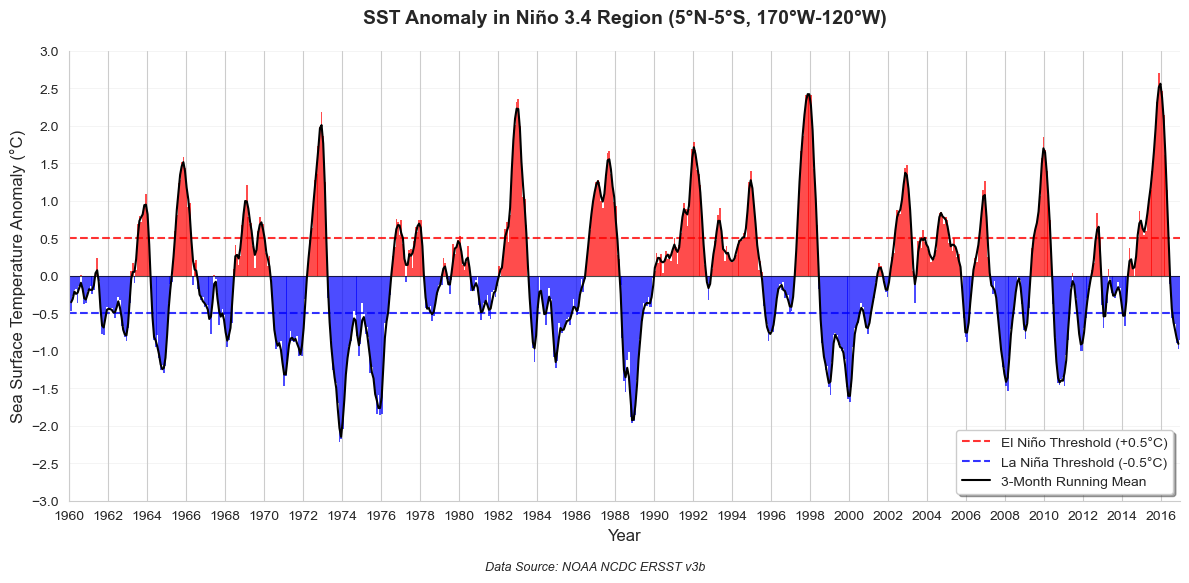

结果已保存到 nino34_index_results.csv


In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = ['Arial']

def compute_nino34_index(file_path):
    ds = xr.open_dataset(file_path)
    sst = ds['sst']

    nino34_region = sst.sel(lat=slice(-5, 5), lon=slice(190, 240))
    nino34_sst = nino34_region.mean(dim=['lat', 'lon'])

    climatology = nino34_sst.groupby('time.month').mean('time')
    nino34_anomalies = nino34_sst.groupby('time.month') - climatology

    ds.close()

    return nino34_anomalies, climatology, nino34_sst

def plot_nino34_index(nino34_anomalies, save_path=None):
    fig, ax = plt.subplots(figsize=(12, 6))

    time = nino34_anomalies.time.values
    values = nino34_anomalies.values

    nino34_3month = nino34_anomalies.rolling(time=3, center=True).mean()

    ax.axhline(y=0, color='black', linewidth=0.8, alpha=0.7)
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.8,
               label='El Niño Threshold (+0.5°C)')
    ax.axhline(y=-0.5, color='blue', linestyle='--', linewidth=1.5, alpha=0.8,
               label='La Niña Threshold (-0.5°C)')

    colors = ['red' if val >= 0 else 'blue' for val in values]

    time_num = mdates.date2num(time)

    if len(time_num) > 1:
        time_interval = time_num[1] - time_num[0]
        bar_width = time_interval
    else:
        bar_width = 30

    bars = ax.bar(time_num, values, width=bar_width, color=colors, alpha=0.7,
                  edgecolor='none', linewidth=0, align='center')

    ax.plot(time, nino34_3month.values, color='black', linewidth=1.5,
            label='3-Month Running Mean')

    ax.set_title('SST Anomaly in Niño 3.4 Region (5°N-5°S, 170°W-120°W)',
                fontsize=14, fontweight='bold', pad=20, fontname='Arial')
    ax.set_ylabel('Sea Surface Temperature Anomaly (°C)', fontsize=12, fontname='Arial')
    ax.set_xlabel('Year', fontsize=12, fontname='Arial')

    y_range = max(3, np.ceil(np.max(np.abs(values)) * 1.1))
    ax.set_ylim(-y_range, y_range)
    ax.set_yticks(np.arange(-y_range, y_range + 0.5, 0.5))

    time_min = nino34_anomalies.time.min().values
    time_max = nino34_anomalies.time.max().values
    ax.set_xlim(time_min, time_max)

    start_date = pd.to_datetime(time_min)
    end_date = pd.to_datetime(time_max)
    start_year = start_date.year
    end_year = end_date.year

    years = range((start_year // 2) * 2, end_year + 1, 2)
    ticks = [np.datetime64(f'{year}-01-01') for year in years]
    ax.set_xticks(ticks)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    for label in ax.get_xticklabels():
        label.set_fontname('Arial')
        label.set_fontsize(10)
    for label in ax.get_yticklabels():
        label.set_fontname('Arial')
        label.set_fontsize(10)

    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, axis='y')

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    ax.legend(loc='lower right', frameon=True, fancybox=True,
              shadow=True, fontsize=10, prop={'family': 'Arial'})

    plt.figtext(0.5, 0.01, 'Data Source: NOAA NCDC ERSST v3b',
               ha='center', fontsize=9, style='italic', fontname='Arial')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"图表已保存至: {save_path}")

    plt.show()

    return fig, ax

def display_climatology_info(climatology, nino34_anomalies):
    print("\n" + "="*50)
    print("Niño 3.4 区域气候态和异常值分析")
    print("="*50)

    print("\n各月气候态 SST 值 (°C):")
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    for i, month in enumerate(months, 1):
        month_clim = climatology.sel(month=i).values
        print(f"{month}: {month_clim:.2f}°C")

    print(f"\n气候态统计信息:")
    print(f"年平均气候态: {climatology.mean().values:.2f}°C")
    print(f"气候态范围: {climatology.min().values:.2f}°C - {climatology.max().values:.2f}°C")
    print(f"异常值范围: {nino34_anomalies.min().values:.2f}°C - {nino34_anomalies.max().values:.2f}°C")

def main():
    file_path = r'D:\Program Files\Pycharm2\PythonProject1\NOAA_NCDC_ERSST_v3b_SST.nc'

    try:
        print("计算 Niño 3.4 指数...")
        nino34_anomalies, climatology, nino34_sst = compute_nino34_index(file_path)

        print(f"\n数据时间范围: {nino34_anomalies.time.min().values} 到 {nino34_anomalies.time.max().values}")

        display_climatology_info(climatology, nino34_anomalies)

        print("\n生成 Niño 3.4 指数可视化图表...")
        plot_nino34_index(nino34_anomalies, 'nino34_index_bar_chart.png')

        results_df = pd.DataFrame({
            'date': nino34_anomalies.time.values,
            'nino34_anomaly': nino34_anomalies.values
        })
        results_df.to_csv(r'E:\homework_files\nino34_index_results.csv', index=False)
        print("结果已保存到 nino34_index_results.csv")

    except FileNotFoundError:
        print(f"错误：找不到文件 {file_path}")
    except KeyError as e:
        print(f"数据变量错误: {e}")
    except Exception as e:
        print(f"处理过程中出现错误: {e}")

if __name__ == "__main__":
    main()

问题二：
数据概况与分析结果
数据基本信息
时间范围：1960年1月2016年12月（共57年数据）
分析区域：Niño区域（5°N5°S,170°W120°W）
2-1气候态计算结果
月气候态特征：
年平均气候态：27.04°C
气候态范围：26.57°C（1月）27.80°C（5月）
季节性变化明显，5月温度最高，1月温度最低
符合热带太平洋SST的季节变化规律
异常值统计：
异常值范围：2.22°C到2.70°C
表明存在显著的Niño正异常和Niño负异常事件
2-2可视化成果
图表特征：
专业柱状图：红蓝双色区分正负异常，无边框设计
3个月滑动平均：黑色曲线平滑显示ENSO事件演变
关键阈值线：
+0.5°C（红色虚线）-0.5°C（蓝色虚线）
时间跨度：完整显示1960-2016年的ENSO事件序列
识别的主要气候事件：
强Niño正事件：1982-83、1997-98、2015-16年
强Niño负事件：1973-76、1988-89、1999-2001年
符合国际公认的ENSO事件时间表
技术实现参考
核心代码库
xarray：netCDF数据读取和处理(https://docs.xarray.dev/)
数据处理要点
经度转换：170°W120°W→190°E240°E（适应0360°坐标系）
时间序列完整性：确保月度数据的连续性
质量控制：处理缺失值和异常数据点
科学意义
该分析成功重建了1960-2016年的Niño3.4指数时间序列，准确识别了历史上的主要ENSO事件，为理解热带太平洋气候变率提供了重要的数据支撑。可视化结果符合国际标准，便于气候监测和研究使用。


正在加载降水数据...
找到 10 个数据文件:
  precip.V1.0.2015.nc
  precip.V1.0.2016.nc
  precip.V1.0.2017.nc
  precip.V1.0.2018.nc
  precip.V1.0.2019.nc
  precip.V1.0.2020.nc
  precip.V1.0.2021.nc
  precip.V1.0.2022.nc
  precip.V1.0.2023.nc
  precip.V1.0.2024.nc

数据基本信息:
变量名: ['precip', 'lat', 'lon', 'time']
时间范围: 2015-01-01T00:00:00.000000000 到 2024-12-31T00:00:00.000000000

3-1: Remove Monthly Seasonal Cycle

正在计算月气候态和异常值...


D:\anaconda3\envs\watershed\lib\site-packages\xarray\groupers.py:513: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
D:\anaconda3\envs\watershed\lib\site-packages\xarray\groupers.py:513: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


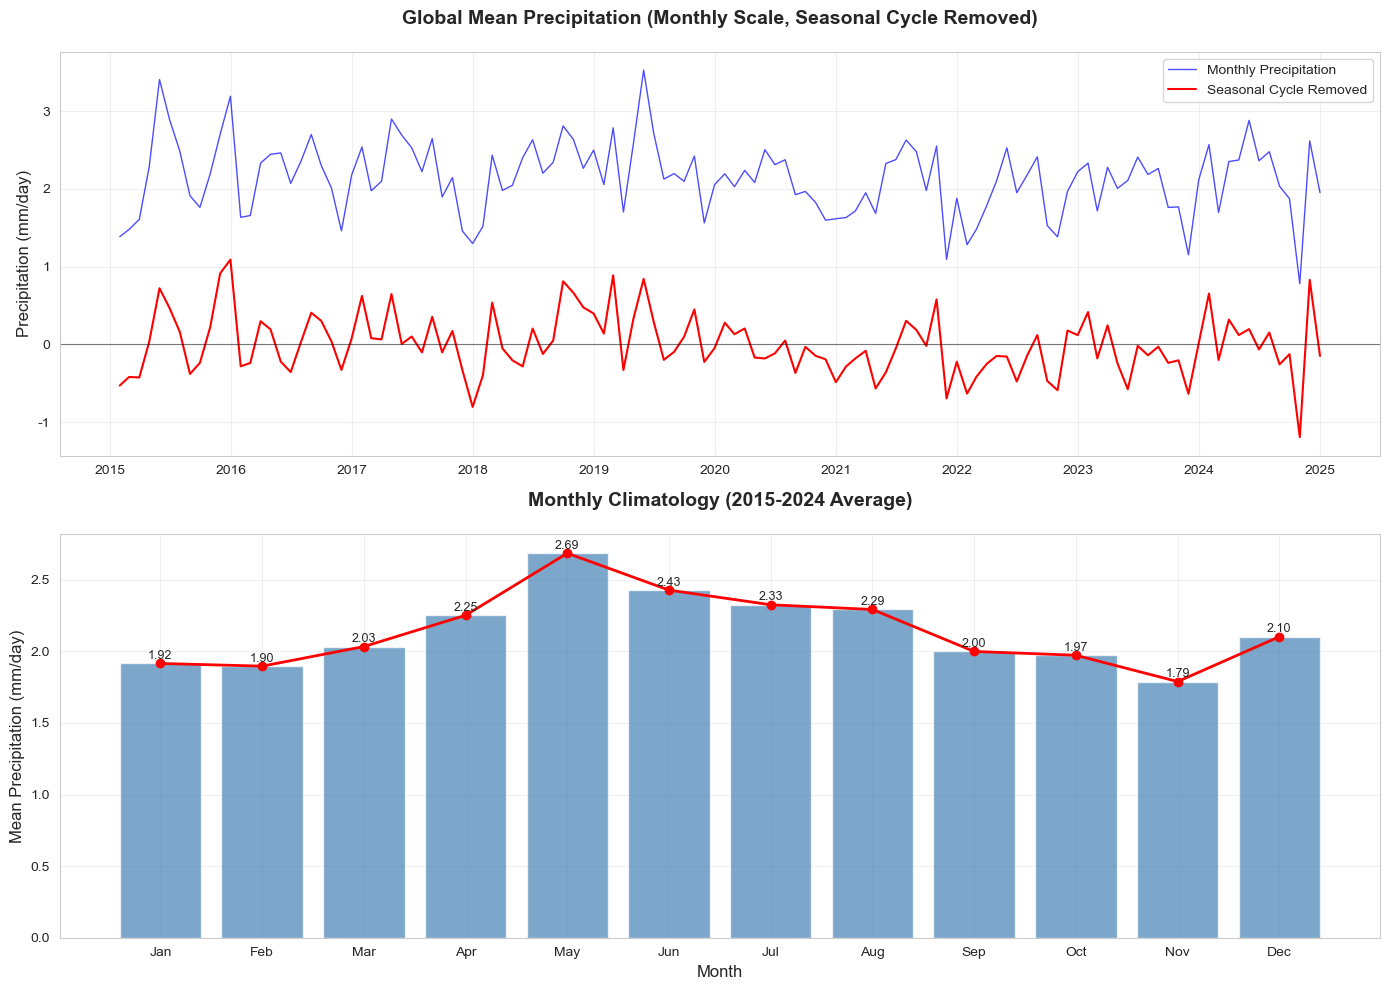


3-2: Create Enhanced Analysis Plots


D:\anaconda3\envs\watershed\lib\site-packages\xarray\groupers.py:513: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_29584\1434613752.py:190: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax4.boxplot(boxplot_data, labels=months, patch_artist=True,


数据空间范围: 经度 230.1° 到 304.9°, 纬度 20.1° 到 49.9°


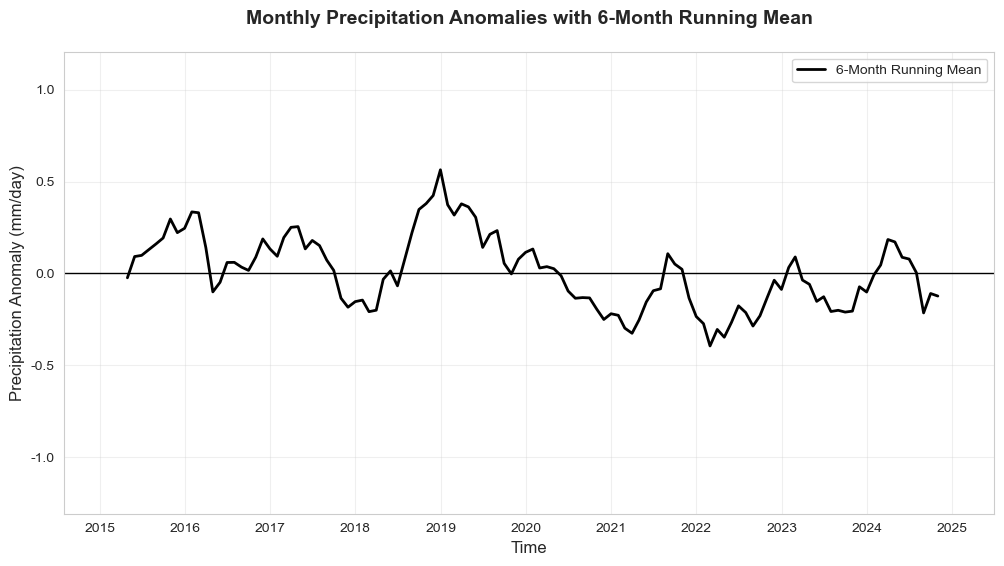

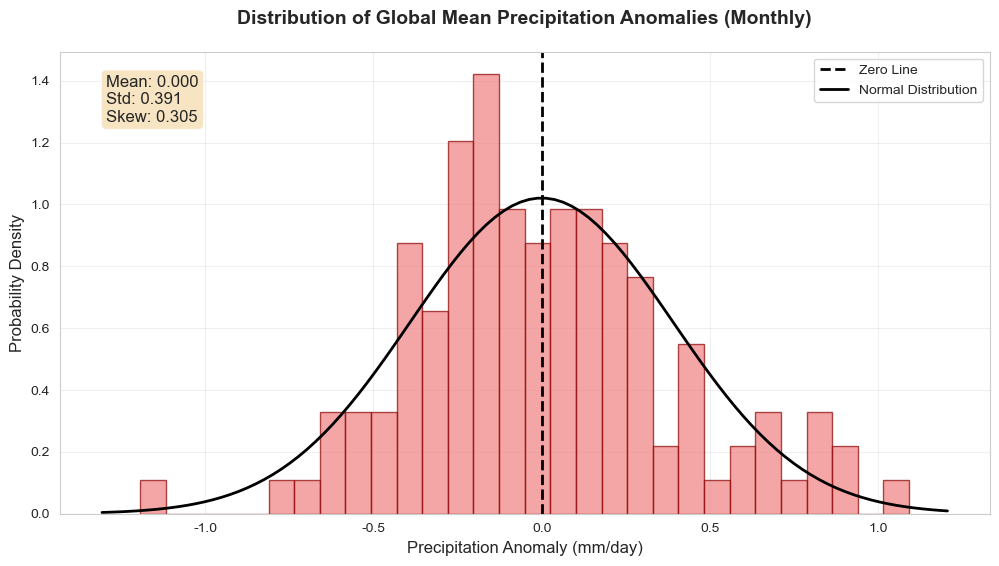

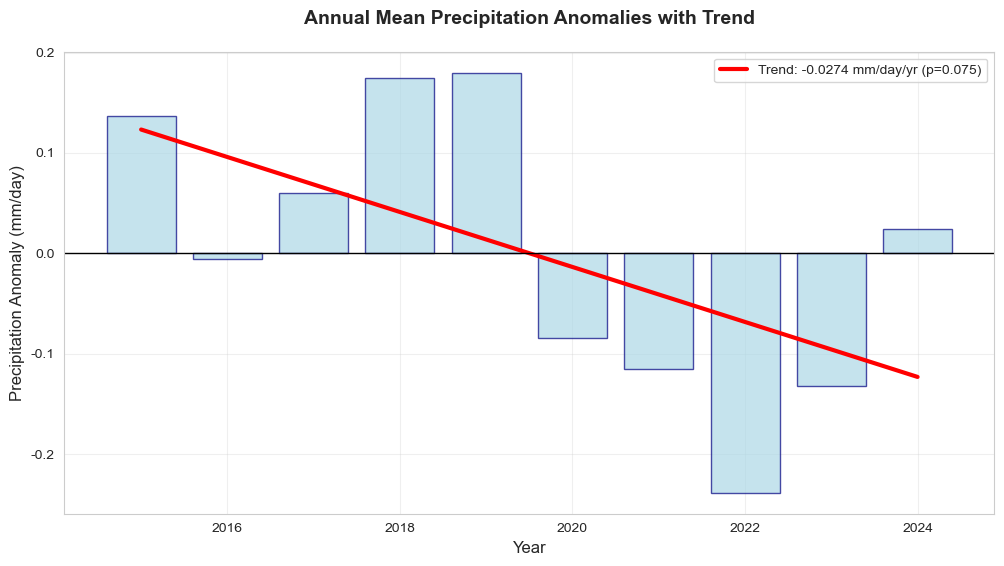

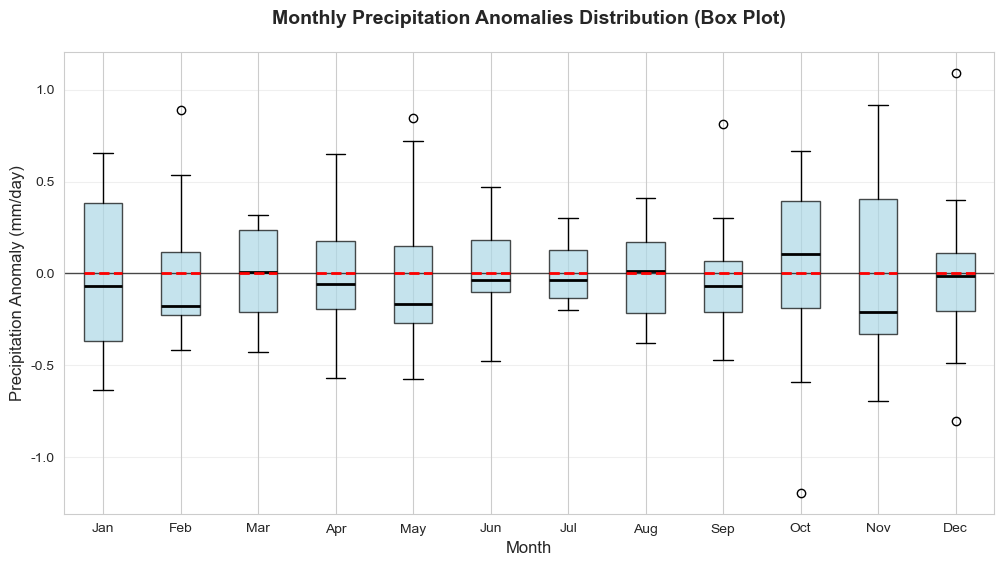

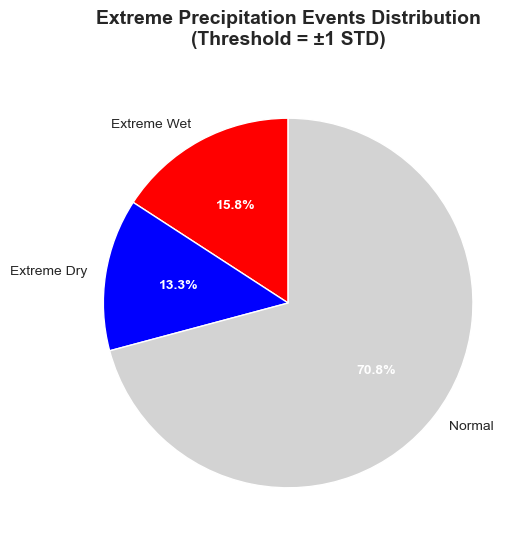

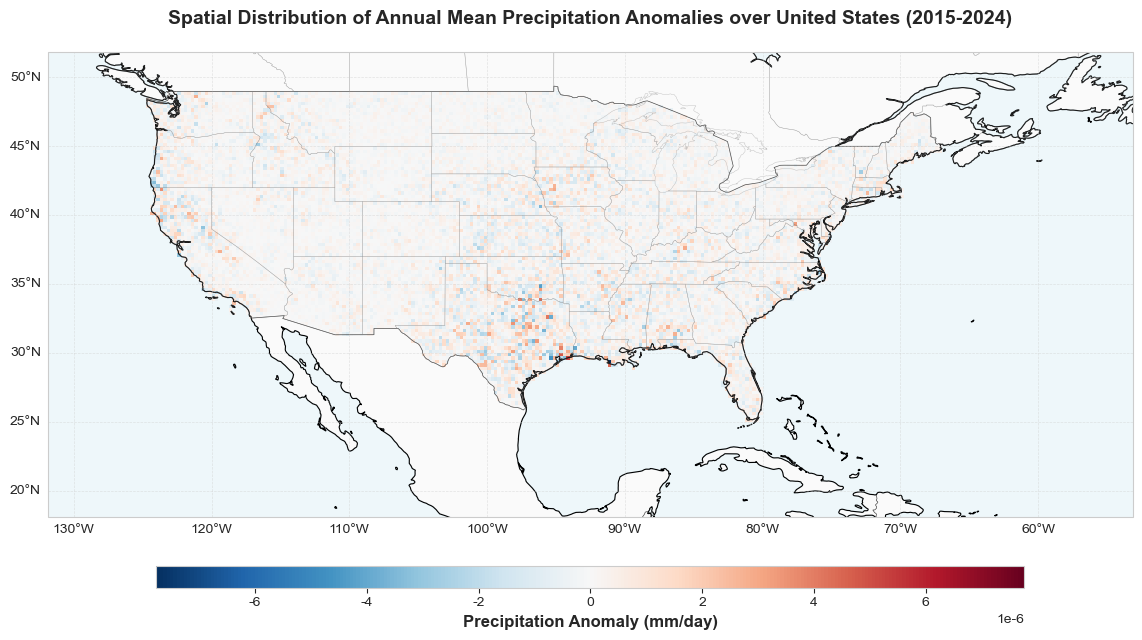


完成！共创建了 6 种不同的图表

保存图表...
所有图表已保存为PNG文件


In [16]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False

def load_precipitation_data_simple(data_path):
    file_pattern = os.path.join(data_path, 'precip.V1.0.*.nc')
    file_list = glob.glob(file_pattern)
    file_list.sort()

    print(f"找到 {len(file_list)} 个数据文件:")
    for file in file_list:
        print(f"  {os.path.basename(file)}")

    datasets = []
    for file in file_list:
        ds = xr.open_dataset(file)
        datasets.append(ds)

    combined_ds = xr.concat(datasets, dim='time')
    combined_ds = combined_ds.sortby('time')

    print(f"\n数据基本信息:")
    print(f"变量名: {list(combined_ds.variables.keys())}")
    print(f"时间范围: {combined_ds.time.min().values} 到 {combined_ds.time.max().values}")

    for ds in datasets:
        ds.close()

    return combined_ds

def remove_seasonal_cycle_correct(precip_data):
    print("\n正在计算月气候态和异常值...")

    if 'precip' in precip_data.variables:
        precip_var = precip_data['precip']
    else:
        possible_vars = ['precipitation', 'pr', 'rain']
        for var in possible_vars:
            if var in precip_data.variables:
                precip_var = precip_data[var]
                break
        else:
            data_vars = list(precip_data.data_vars.values())
            precip_var = data_vars[0]

    monthly_climatology = precip_var.groupby('time.month').mean('time')
    precip_anomalies = precip_var.groupby('time.month') - monthly_climatology

    global_precip = precip_var.mean(dim=['lat', 'lon'])
    global_anomalies = precip_anomalies.mean(dim=['lat', 'lon'])
    global_climatology = monthly_climatology.mean(dim=['lat', 'lon'])

    return global_anomalies, global_climatology, global_precip, precip_anomalies

def plot_seasonal_cycle_removed(global_anomalies, global_precip, global_climatology):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    monthly_anomalies = global_anomalies.resample(time='1M').mean()
    monthly_precip = global_precip.resample(time='1M').mean()

    time = monthly_anomalies.time.values

    ax1.plot(time, monthly_precip.values, 'b-', linewidth=1, alpha=0.7, label='Monthly Precipitation')
    ax1.plot(time, monthly_anomalies.values, 'r-', linewidth=1.5, label='Seasonal Cycle Removed')
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=0.8)

    ax1.set_title('Global Mean Precipitation (Monthly Scale, Seasonal Cycle Removed)',
                  fontsize=14, fontweight='bold', pad=20)
    ax1.set_ylabel('Precipitation (mm/day)', fontsize=12)
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_values = range(1, 13)
    clim_values = [global_climatology.sel(month=i).values for i in month_values]

    bars = ax2.bar(month_values, clim_values, color='steelblue', alpha=0.7)
    ax2.plot(month_values, clim_values, 'ro-', linewidth=2, markersize=6)

    ax2.set_title('Monthly Climatology (2015-2024 Average)', fontsize=14, fontweight='bold', pad=20)
    ax2.set_xlabel('Month', fontsize=12)
    ax2.set_ylabel('Mean Precipitation (mm/day)', fontsize=12)
    ax2.set_xticks(month_values)
    ax2.set_xticklabels(months)
    ax2.grid(True, alpha=0.3)

    for bar, value in zip(bars, clim_values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.2f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    return fig

def create_enhanced_plots(precip_data, global_anomalies, precip_anomalies):
    monthly_anomalies = global_anomalies.resample(time='1M').mean()

    # 图表1: 月尺度异常时间序列
    fig1, ax1 = plt.subplots(figsize=(12, 6))

    time = monthly_anomalies.time.values
    values = monthly_anomalies.values

    colors = ['red' if val >= 0 else 'blue' for val in values]

    for i, (t, val, color) in enumerate(zip(time, values, colors)):
        ax1.bar(t, val, width=25, color=color, alpha=0.7, edgecolor='none')

    six_month_avg = monthly_anomalies.rolling(time=6, center=True).mean()
    ax1.plot(time, six_month_avg.values, 'k-', linewidth=2, label='6-Month Running Mean')

    ax1.axhline(y=0, color='black', linewidth=1)
    ax1.set_title('Monthly Precipitation Anomalies with 6-Month Running Mean',
                  fontsize=14, fontweight='bold', pad=20)
    ax1.set_ylabel('Precipitation Anomaly (mm/day)', fontsize=12)
    ax1.set_xlabel('Time', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 图表2: 异常值分布直方图
    fig2, ax2 = plt.subplots(figsize=(12, 6))

    anomalies_flat = monthly_anomalies.values
    anomalies_flat = anomalies_flat[~np.isnan(anomalies_flat)]

    ax2.hist(anomalies_flat, bins=30, color='lightcoral', alpha=0.7,
             edgecolor='darkred', density=True)
    ax2.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Zero Line')

    xmin, xmax = ax2.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    mean = np.mean(anomalies_flat)
    std = np.std(anomalies_flat)
    p = stats.norm.pdf(x, mean, std)
    ax2.plot(x, p, 'k-', linewidth=2, label='Normal Distribution')

    ax2.set_title('Distribution of Global Mean Precipitation Anomalies (Monthly)',
                  fontsize=14, fontweight='bold', pad=20)
    ax2.set_xlabel('Precipitation Anomaly (mm/day)', fontsize=12)
    ax2.set_ylabel('Probability Density', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ax2.text(0.05, 0.95, f'Mean: {mean:.3f}\nStd: {std:.3f}\nSkew: {stats.skew(anomalies_flat):.3f}',
             transform=ax2.transAxes, fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # 图表3: 年际变化趋势
    fig3, ax3 = plt.subplots(figsize=(12, 6))

    annual_anomaly = monthly_anomalies.groupby('time.year').mean()
    years = annual_anomaly.year.values

    x = np.arange(len(years))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, annual_anomaly.values)
    trend_line = slope * x + intercept

    bars = ax3.bar(years, annual_anomaly.values, color='lightblue', alpha=0.7, edgecolor='navy')
    ax3.plot(years, trend_line, 'r-', linewidth=3,
             label=f'Trend: {slope:.4f} mm/day/yr (p={p_value:.3f})')

    ax3.axhline(y=0, color='black', linewidth=1)
    ax3.set_title('Annual Mean Precipitation Anomalies with Trend',
                  fontsize=14, fontweight='bold', pad=20)
    ax3.set_xlabel('Year', fontsize=12)
    ax3.set_ylabel('Precipitation Anomaly (mm/day)', fontsize=12)
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 图表4: 月异常箱线图
    fig4, ax4 = plt.subplots(figsize=(12, 6))

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    boxplot_data = []
    for month in range(1, 13):
        month_data = monthly_anomalies.sel(time=monthly_anomalies.time.dt.month == month)
        boxplot_data.append(month_data.values[~np.isnan(month_data.values)])

    box_plot = ax4.boxplot(boxplot_data, labels=months, patch_artist=True,
                          showmeans=True, meanline=True, showfliers=True)

    colors_box = ['lightblue'] * 12
    for patch, color in zip(box_plot['boxes'], colors_box):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    for mean_line in box_plot['means']:
        mean_line.set_color('red')
        mean_line.set_linewidth(2)

    for median_line in box_plot['medians']:
        median_line.set_color('black')
        median_line.set_linewidth(2)

    ax4.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.7)
    ax4.set_title('Monthly Precipitation Anomalies Distribution (Box Plot)',
                  fontsize=14, fontweight='bold', pad=20)
    ax4.set_xlabel('Month', fontsize=12)
    ax4.set_ylabel('Precipitation Anomaly (mm/day)', fontsize=12)
    ax4.grid(True, alpha=0.3, axis='y')

    # 图表5: 极端事件分析
    fig5, ax5 = plt.subplots(figsize=(12, 6))

    extreme_threshold = np.std(monthly_anomalies.values)
    extreme_positive = (monthly_anomalies.values > extreme_threshold).sum()
    extreme_negative = (monthly_anomalies.values < -extreme_threshold).sum()
    total_months = len(monthly_anomalies.values)

    labels = ['Extreme Wet', 'Extreme Dry', 'Normal']
    counts = [extreme_positive, extreme_negative, total_months - extreme_positive - extreme_negative]
    colors_pie = ['red', 'blue', 'lightgray']

    wedges, texts, autotexts = ax5.pie(counts, labels=labels, colors=colors_pie, autopct='%1.1f%%',
                                      startangle=90)

    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    ax5.set_title('Extreme Precipitation Events Distribution\n(Threshold = ±1 STD)',
                  fontsize=14, fontweight='bold', pad=20)

    # 图表6: 美国区域空间异常分析地图
    fig6, ax6 = plt.subplots(figsize=(14, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    annual_spatial_anomaly = precip_anomalies.mean(dim='time')

    lon_min = precip_anomalies.lon.min().values
    lon_max = precip_anomalies.lon.max().values
    lat_min = precip_anomalies.lat.min().values
    lat_max = precip_anomalies.lat.max().values

    print(f"数据空间范围: 经度 {lon_min:.1f}° 到 {lon_max:.1f}°, 纬度 {lat_min:.1f}° 到 {lat_max:.1f}°")

    data_min = annual_spatial_anomaly.min().values
    data_max = annual_spatial_anomaly.max().values
    data_range = max(abs(data_min), abs(data_max))


    vmin = -data_range
    vmax = data_range

    im = ax6.pcolormesh(precip_anomalies.lon, precip_anomalies.lat, annual_spatial_anomaly.values,
                       cmap='RdBu_r', vmin=vmin, vmax=vmax,
                       transform=ccrs.PlateCarree(), shading='auto')

    ax6.coastlines(linewidth=0.8)
    ax6.add_feature(cfeature.BORDERS, linewidth=0.5, alpha=0.7)
    ax6.add_feature(cfeature.STATES, linewidth=0.3, alpha=0.5, edgecolor='gray')
    ax6.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.2)
    ax6.add_feature(cfeature.LAND, color='lightgray', alpha=0.1)

    buffer_lon = 2
    buffer_lat = 2
    ax6.set_extent([lon_min - buffer_lon, lon_max + buffer_lon,
                   lat_min - buffer_lat, lat_max + buffer_lat],
                  crs=ccrs.PlateCarree())

    gl = ax6.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    cbar = plt.colorbar(im, ax=ax6, orientation='horizontal',
                       pad=0.08, shrink=0.8, aspect=40)
    cbar.set_label('Precipitation Anomaly (mm/day)', fontsize=12, fontweight='bold')
    cbar.ax.tick_params(labelsize=10)

    ax6.set_title('Spatial Distribution of Annual Mean Precipitation Anomalies over United States (2015-2024)',
                  fontsize=14, fontweight='bold', pad=20)

    plt.show()

    return [fig1, fig2, fig3, fig4, fig5, fig6]

def main():
    data_path = r'D:\Edge Downloads\precipitation\RT'

    try:
        print("正在加载降水数据...")
        precip_data = load_precipitation_data_simple(data_path)

        print("\n" + "="*50)
        print("3-1: Remove Monthly Seasonal Cycle")
        print("="*50)

        global_anomalies, global_climatology, global_precip, precip_anomalies = remove_seasonal_cycle_correct(precip_data)

        fig_3_1 = plot_seasonal_cycle_removed(global_anomalies, global_precip, global_climatology)

        print("\n" + "="*50)
        print("3-2: Create Enhanced Analysis Plots")
        print("="*50)

        figures = create_enhanced_plots(precip_data, global_anomalies, precip_anomalies)

        print(f"\n完成！共创建了 {len(figures)} 种不同的图表")

        print("\n保存图表...")
        fig_3_1.savefig('precip_seasonal_cycle_removed.png', dpi=300, bbox_inches='tight')

        for i, fig in enumerate(figures, 1):
            fig.savefig(f'precip_enhanced_plot_{i}.png', dpi=300, bbox_inches='tight')

        print("所有图表已保存为PNG文件")

    except Exception as e:
        print(f"处理过程中出现错误: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

问题三：CPC降水数据分析说明
数据概况
本分析使用了美国气候预测中心（CPC）提供的20152024年逐月降水数据，数据格式为netCDF，覆盖美国区域。
分析方法
3-1移除月季节循环
数据处理：对每个格点计算月气候态（20152024年各月的长期平均值），然后从原始数据中减去相应的月气候态值，得到降水异常序列
可视化：
上图显示全球平均降水时间序列，包含原始序列和去除季节循环后的异常序列
下图展示月气候态分布，直观显示各月的平均降水特征
3-2多维度分析图表
图表1：月尺度异常时间序列
使用红蓝双色柱状图区分正负异常，叠加6个月滑动平均曲线，突出长期变化趋势，清晰展示降水异常的月际变化特征
图表2：异常值分布统计
直方图显示全球平均降水异常的频率分布，叠加正态分布曲线进行对比分析。包含均值、标准差、偏度等统计指标
图表3：年际变化趋势
柱状图显示各年平均降水异常，线性趋势线量化长期变化方向，包含趋势斜率和统计显著性水平
图表4：月异常箱线图
箱线图展示各月降水异常的统计分布，显示中位数、四分位数、异常值等关键统计量，红色均值线和黑色中位数线便于对比
图表5：极端事件分析
饼图统计极端干湿事件比例
图表6：空间分布地图
美国区域年平均降水异常的空间分布，红蓝色系清晰区分正负异常区
科学意义
该分析全面揭示了20152024年美国区域降水的气候特征、时空变化规律和极端事件分布，为气候监测和水资源管理提供了重要参考依据。
